# Post-Projection Head Analysis: $\widehat{\mathbf{r}}_{\ell,b,h} \in \mathbb{R}^{D_\ell}$
This notebook mirrors the pre-projection analysis but operates on the
**post-projection** per-head representations $\widehat{\mathbf{r}}_{\ell,b,h}$,
i.e. the spatially-pooled contributions of each head to the residual stream
after applying $W^O_{\ell,b,h}$.

**Key difference from pre-projection analysis.**
Pre-projection heads all live in $\mathbb{R}^{d_h=24}$, so metrics are
directly comparable across stages. Post-projection heads live in
$\mathbb{R}^{D_\ell}$ with $D_\ell \in \{96, 192, 384, 768\}$: the ambient
dimension doubles at each stage transition. This has two consequences:

1. **PCA-based thresholds** (e.g. `pca_99`) have a higher ceiling at later
   stages — a head at Stage 3 can use up to 768 components, one at Stage 0
   only 96. Cross-stage comparisons of absolute dimensionality must account
   for this.
2. **Similarity/distance metrics** between heads of different stages are
   undefined (different spaces), so the similarity matrix is computed
   on *normalised spectra of fixed length*, truncated to the minimum
   stage dimensionality.
   
Within a single stage all comparisons are well-defined and unambiguous.

## Cell 0 — Imports & Configuration

In [1]:
import torch
import numpy as np
from tqdm.notebook import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr, pearsonr, linregress

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

from skdim.id import TwoNN, MLE

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
import seaborn as sns
import pandas as pd

# ── Architecture constants ────────────────────────────────────────────────────
HTSAT_DEPTHS = [2, 2, 6, 2]
HTSAT_HEADS  = [4, 8, 16, 32]
HTSAT_EMBED  = 96
HEAD_DIM     = 24   # d_h, constant

# D_ell for each stage
STAGE_DIMS   = [HTSAT_EMBED * (2 ** l) for l in range(4)]   # [96, 192, 384, 768]

COLORS = {
    'layer0': '#2d77a6',
    'layer1': '#bf7b04',
    'layer2': '#6ea66d',
    'layer3': '#808080',
    'accent': '#d62728',
    'neutral': '#7f7f7f'
}
layer_colors = {i: COLORS[f'layer{i}'] for i in range(4)}

plt.style.use('seaborn-v0_8-paper')
sns.set_context("paper", font_scale=1.2)
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'mathtext.fontset': 'stix',
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 13,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.axisbelow': True
})

## Cell 1 — Load Post-Projection Data

In [2]:
print("=" * 80)
print("LOADING POST-PROJECTION HEAD REPRESENTATIONS")
print("=" * 80)

DATASET = "ESC50"
loaded  = torch.load(
    f'heads_representations/{DATASET.lower()}_postproj_head_outputs.pt',
    map_location="cpu", weights_only=False
)
postproj_head_outputs = loaded["postproj_head_outputs"]
sample_labels         = loaded["labels"]

n_samples = len(sample_labels)
n_classes = len(np.unique(sample_labels))
print(f"✓ Loaded {len(postproj_head_outputs)} heads, {n_samples} samples")
print(f"✓ Dataset: {n_samples} samples, {n_classes} classes")
print(f"✓ Class distribution: {np.bincount(sample_labels)}")

# Verify shapes
print("\n▸ Shape verification by stage:")
for layer_idx, (depth, n_heads) in enumerate(zip(HTSAT_DEPTHS, HTSAT_HEADS)):
    D_ell = STAGE_DIMS[layer_idx]
    for block_idx in range(depth):
        for h in range(n_heads):
            head_id = f"L{layer_idx}_B{block_idx}_H{h}"
            t = postproj_head_outputs[head_id]
            assert t.shape == (n_samples, D_ell), \
                f"Shape mismatch {head_id}: {t.shape} vs ({n_samples},{D_ell})"
    print(f"   Stage {layer_idx} (D={D_ell}): {depth * n_heads} heads ✅")


LOADING POST-PROJECTION HEAD REPRESENTATIONS
✓ Loaded 184 heads, 2000 samples
✓ Dataset: 2000 samples, 50 classes
✓ Class distribution: [40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40]

▸ Shape verification by stage:
   Stage 0 (D=96): 8 heads ✅
   Stage 1 (D=192): 16 heads ✅
   Stage 2 (D=384): 96 heads ✅
   Stage 3 (D=768): 64 heads ✅


## Cell 2 — Intrinsic Dimensionality Analysis

Same metrics as the pre-projection notebook. The critical difference is
`head_dim` (the ambient ceiling) which is now $D_\ell$ instead of 24.
We store it explicitly in `id_df` so that all normalised comparisons
can use it.

In [3]:
print("\n" + "=" * 80)
print("INTRINSIC DIMENSIONALITY ANALYSIS (post-projection)")
print("=" * 80)

def compute_intrinsic_dim_metrics(X):
    """
    Compute multiple intrinsic dimensionality estimators.
    Identical to pre-projection version; ambient dim is inferred from X.shape[1].
    """
    metrics = {}
    pca = PCA(n_components=min(X.shape))
    pca.fit(X)
    eigenvalues  = pca.explained_variance_
    evr          = pca.explained_variance_ratio_
    evr_cumsum   = np.cumsum(evr)

    metrics['pca_90']  = int(np.argmax(evr_cumsum >= 0.90) + 1)
    metrics['pca_95']  = int(np.argmax(evr_cumsum >= 0.95) + 1)
    metrics['pca_99']  = int(np.argmax(evr_cumsum >= 0.99) + 1)
    metrics['evr_pc1'] = float(evr[0])
    metrics['evr_pc2'] = float(evr[1]) if len(evr) > 1 else 0.0
    metrics['evr_pc3'] = float(evr[2]) if len(evr) > 2 else 0.0
    metrics['pr']      = float((eigenvalues.sum() ** 2) / (eigenvalues ** 2).sum())

    try:
        metrics['twonn'] = float(TwoNN().fit_transform(X))
    except Exception:
        metrics['twonn'] = np.nan

    try:
        metrics['mle'] = float(MLE().fit_transform(X))
    except Exception:
        metrics['mle'] = np.nan

    evr_norm = evr / evr.sum()
    metrics['shannon_entropy'] = float(-np.sum(evr_norm * np.log(evr_norm + 1e-10)))
    metrics['eff_rank']        = float(np.exp(metrics['shannon_entropy']))
    return metrics, pca


print("\n▸ Computing metrics for all 184 heads...")
head_id_results = {}

for head_id, head_repr in tqdm(postproj_head_outputs.items(), desc="ID Analysis"):
    X = head_repr.numpy()
    metrics, pca = compute_intrinsic_dim_metrics(X)

    layer = int(head_id.split('_')[0][1])
    block = int(head_id.split('_')[1][1])
    head  = int(head_id.split('_')[2][1])

    head_id_results[head_id] = {
        **metrics,
        'layer':    layer,
        'block':    block,
        'head':     head,
        'pca_obj':  pca,
        'head_dim': X.shape[1],           # D_ell — varies by stage
        'D_ell':    STAGE_DIMS[layer],
    }

id_df = pd.DataFrame(head_id_results).T.reset_index().rename(columns={'index': 'head_id'})

# Convert numeric columns
string_cols = {'head_id', 'pca_obj'}
for col in id_df.columns:
    if col not in string_cols:
        id_df[col] = pd.to_numeric(id_df[col], errors='coerce')

# Global block index
def get_global_block(row):
    return int(sum(HTSAT_DEPTHS[:int(row['layer'])]) + row['block'])

id_df['global_block'] = id_df.apply(get_global_block, axis=1)

print(f"✓ Analysis complete: {len(id_df)} heads")

# ── Statistical summary ───────────────────────────────────────────────────────
print("\n▸ Statistical Summary by Stage:")
print("  (pca_99 ceiling: Stage 0=96, Stage 1=192, Stage 2=384, Stage 3=768)")
summary = id_df.groupby('layer').agg({
    'pca_90': ['mean', 'std', 'max'],
    'pca_99': ['mean', 'std', 'max'],
    'D_ell':  ['first'],
    'twonn':  ['mean', 'std'],
    'pr':     ['mean', 'std'],
    'eff_rank': ['mean', 'std'],
    'evr_pc1':  ['mean', 'std'],
})
print(summary.to_string())

# ── ANOVA ─────────────────────────────────────────────────────────────────────
print("\n▸ One-way ANOVA across stages:")
for metric in ['pca_90', 'pca_99', 'twonn', 'pr', 'eff_rank']:
    groups  = [id_df[id_df['layer'] == l][metric].dropna().values for l in range(4)]
    f, p    = stats.f_oneway(*groups)
    sig     = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'n.s.'
    print(f"  {metric:14s}: F={f:.3f}, p={p:.4f} {sig}")



INTRINSIC DIMENSIONALITY ANALYSIS (post-projection)

▸ Computing metrics for all 184 heads...


ID Analysis:   0%|          | 0/184 [00:00<?, ?it/s]

✓ Analysis complete: 184 heads

▸ Statistical Summary by Stage:
  (pca_99 ceiling: Stage 0=96, Stage 1=192, Stage 2=384, Stage 3=768)
         pca_90                   pca_99               D_ell     twonn                   pr             eff_rank             evr_pc1          
           mean       std max       mean       std max first      mean       std       mean       std       mean       std      mean       std
layer                                                                                                                                         
0       2.00000  1.069045   4   4.125000  2.167124   9    96  5.030300  1.273199   1.660055  0.726165   2.139171  1.132315  0.798228  0.168242
1       6.00000  1.712698   8  11.812500  2.713393  15   192  7.191541  0.693019   4.362753  1.546283   6.123543  1.959894  0.425500  0.162914
2      11.06250  3.104538  16  18.427083  3.168080  23   384  8.879241  1.322516   8.591166  3.177600  11.631352  3.610005  0.258717  0.119938
3      1

## Cell 3 — Block-wise Aggregated Metrics Heatmap

Same visualisation as pre-projection. The `max_vals` normalisation bounds
are now scaled to $D_\ell$ instead of the fixed $d_h = 24$ ceiling, so
we compute them dynamically from the data (99th percentile per metric)
to remain honest about the varying ambient dimension.


BLOCK-WISE AGGREGATED METRICS HEATMAP
 Block  D_ell        L    L_rel        N    Ratio     EVR1
     0     96  3.00000 0.031250 4.274053 0.701910 0.903566
     1     96  5.25000 0.054688 5.786547 0.907277 0.692890
     2    192  9.75000 0.050781 7.110609 1.371190 0.514915
     3    192 13.87500 0.072266 7.272473 1.907879 0.336085
     4    384 14.87500 0.038737 7.262597 2.048165 0.333457
     5    384 16.68750 0.043457 8.164577 2.043890 0.326003
     6    384 19.25000 0.050130 8.678486 2.218129 0.256014
     7    384 19.06250 0.049642 9.516356 2.003130 0.229776
     8    384 20.81250 0.054199 9.797992 2.124160 0.194008
     9    384 19.87500 0.051758 9.855441 2.016652 0.213044
    10    768 21.84375 0.028442 9.005709 2.425545 0.199529
    11    768 20.00000 0.026042 8.727675 2.291561 0.248032


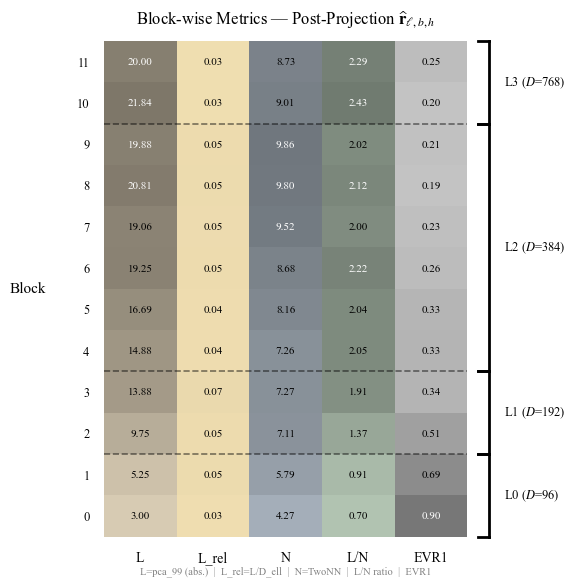

✅ Saved: htsat_block_metrics_postproj.png


In [4]:
print("\n" + "=" * 80)
print("BLOCK-WISE AGGREGATED METRICS HEATMAP")
print("=" * 80)

n_blocks = sum(HTSAT_DEPTHS)

block_metrics_list = []
for b in range(n_blocks):
    block_data = id_df[id_df['global_block'] == b]
    layer_idx  = int(block_data['layer'].iloc[0])
    D_ell      = STAGE_DIMS[layer_idx]

    L      = block_data['pca_99'].mean()
    N      = block_data['twonn'].mean()
    Ratio  = L / N if N > 0 else np.nan
    EVR1   = block_data['evr_pc1'].mean()

    # Relative dimensionality: fraction of ambient space used
    L_rel  = L / D_ell          # ∈ (0, 1]: how much of D_ell is "used"

    block_metrics_list.append({
        'Block':  b,
        'L':      L,
        'L_rel':  L_rel,
        'N':      N,
        'Ratio':  Ratio,
        'EVR1':   EVR1,
        'n_heads': len(block_data),
        'layer':  layer_idx,
        'D_ell':  D_ell,
    })

metrics_df = pd.DataFrame(block_metrics_list)
print(metrics_df[['Block', 'D_ell', 'L', 'L_rel', 'N', 'Ratio', 'EVR1']].to_string(index=False))

# ── Heatmap ───────────────────────────────────────────────────────────────────
# We show both L (absolute) and L_rel (relative to D_ell) so the reader can
# see the raw scale AND the stage-normalised picture side by side.
columns  = ['L', 'L_rel', 'N', 'L/N', 'EVR1']
data_arr = metrics_df[['L', 'L_rel', 'N', 'Ratio', 'EVR1']].values

palette = {
    'L':     np.array([0.9,  0.85, 0.75]),
    'L_rel': np.array([0.95, 0.88, 0.70]),
    'N':     np.array([0.8,  0.85, 0.9 ]),
    'L/N':   np.array([0.8,  0.88, 0.8 ]),
    'EVR1':  np.array([0.85, 0.85, 0.85]),
}

# Dynamic max: 99th percentile of each column (robust to outliers)
max_vals = {
    'L':     float(np.nanpercentile(data_arr[:, 0], 99)),
    'L_rel': 1.0,
    'N':     float(np.nanpercentile(data_arr[:, 2], 99)),
    'L/N':   float(np.nanpercentile(data_arr[:, 3], 99)),
    'EVR1':  float(np.nanpercentile(data_arr[:, 4], 99)),
}

fig, ax = plt.subplots(figsize=(6, n_blocks * 0.5))

# Layer boundary positions
layer_boundaries = [0]
cumsum = 0
for depth in HTSAT_DEPTHS[:-1]:
    cumsum += depth
    layer_boundaries.append(cumsum)
layer_boundaries.append(n_blocks)

for i in range(n_blocks):
    for j, col_name in enumerate(columns):
        val = data_arr[i, j]
        if np.isnan(val):
            continue
        norm       = min(val / max_vals[col_name], 1.0)
        face_color = palette[col_name] * (1 - 0.45 * norm)
        rect       = plt.Rectangle((j, i), 1, 1, facecolor=face_color, edgecolor=None)
        ax.add_patch(rect)
        text_color = 'white' if np.mean(face_color) < 0.5 else 'black'
        ax.text(j + 0.5, i + 0.5, f"{val:.2f}",
                ha='center', va='center', fontsize=8,
                fontweight='bold', color=text_color)

# Layer boundary lines
for boundary in layer_boundaries[1:-1]:
    ax.axhline(y=boundary, color='k', linewidth=1.2, linestyle='--', alpha=0.5)

# Layer brackets on the right
bracket_x = len(columns) + 0.3
for layer_idx in range(len(HTSAT_DEPTHS)):
    y_start = layer_boundaries[layer_idx]
    y_end   = layer_boundaries[layer_idx + 1]
    y_mid   = (y_start + y_end) / 2
    ax.plot([bracket_x, bracket_x], [y_start, y_end], 'k-', linewidth=2, clip_on=False)
    ax.plot([bracket_x, bracket_x - 0.15], [y_start, y_start], 'k-', linewidth=2, clip_on=False)
    ax.plot([bracket_x, bracket_x - 0.15], [y_end,   y_end  ], 'k-', linewidth=2, clip_on=False)
    ax.text(bracket_x + 0.2, y_mid,
            f'L{layer_idx} ($D$={STAGE_DIMS[layer_idx]})',
            ha='left', va='center', fontsize=9, fontweight='bold', clip_on=False)

ax.set_xlim(0, len(columns))
ax.set_ylim(0, n_blocks)
ax.set_xticks(np.arange(len(columns)) + 0.5)
ax.set_xticklabels(columns, fontsize=10, fontweight='bold')
ax.set_yticks(np.arange(n_blocks) + 0.5)
ax.set_yticklabels([str(b) for b in range(n_blocks)], fontsize=9)
ax.set_ylabel('Block', fontsize=11, fontweight='bold', rotation=0, labelpad=35, va='center')
ax.set_title(r'Block-wise Metrics — Post-Projection $\widehat{\mathbf{r}}_{\ell,b,h}$',
             fontsize=12, fontweight='bold', pad=12)
ax.tick_params(left=False, top=False, bottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)

# Column subtitle annotation
ax.text(0.5, -0.06, 'L=pca_99 (abs.)  |  L_rel=L/D_ell  |  N=TwoNN  |  L/N ratio  |  EVR1',
        transform=ax.transAxes, ha='center', va='top', fontsize=7.5,
        color='gray', style='italic')

plt.tight_layout()
plt.savefig('htsat_block_metrics_postproj.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: htsat_block_metrics_postproj.png")

## Cell 4 — Panel Plots (Panels A–H)

Mirrors Panels A–H of the pre-projection analysis.
The main adaptation is that scatter plots use `D_ell`-normalised metrics
where cross-stage comparison would otherwise be confounded.

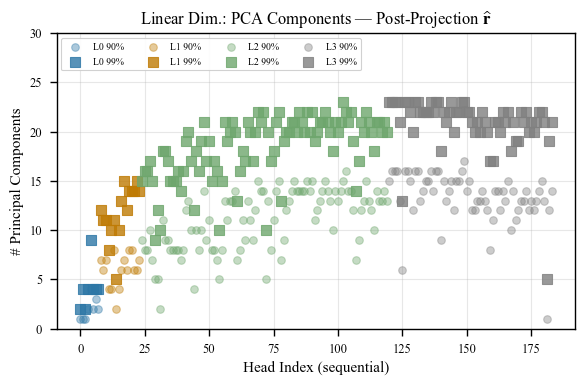

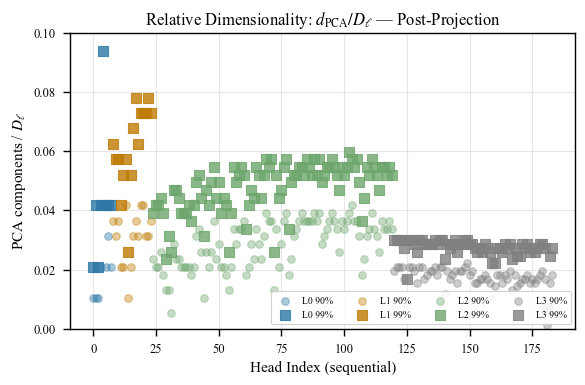

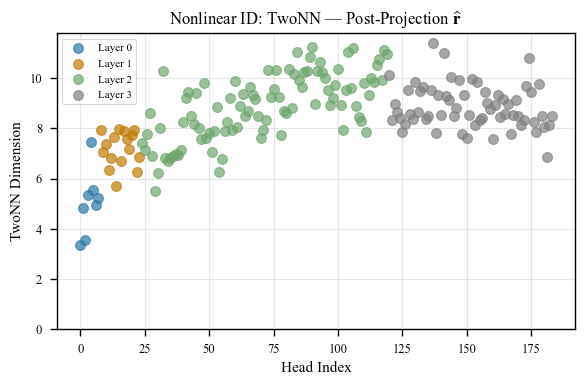

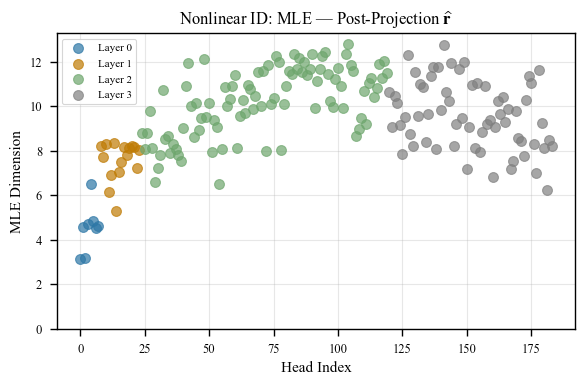

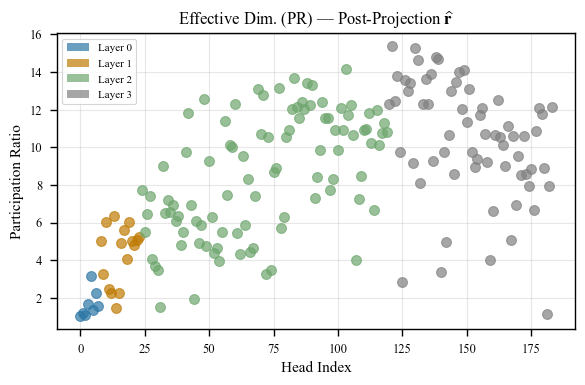

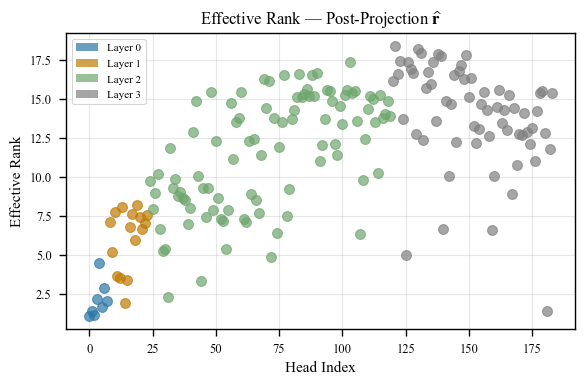

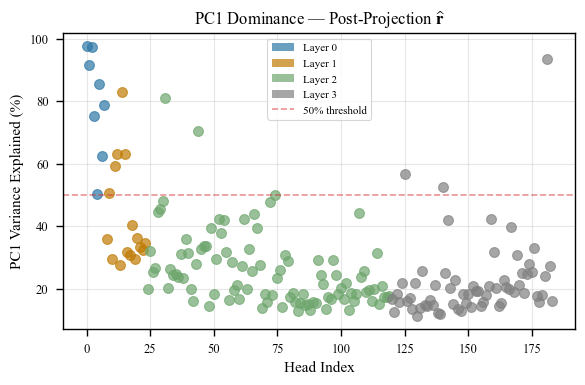

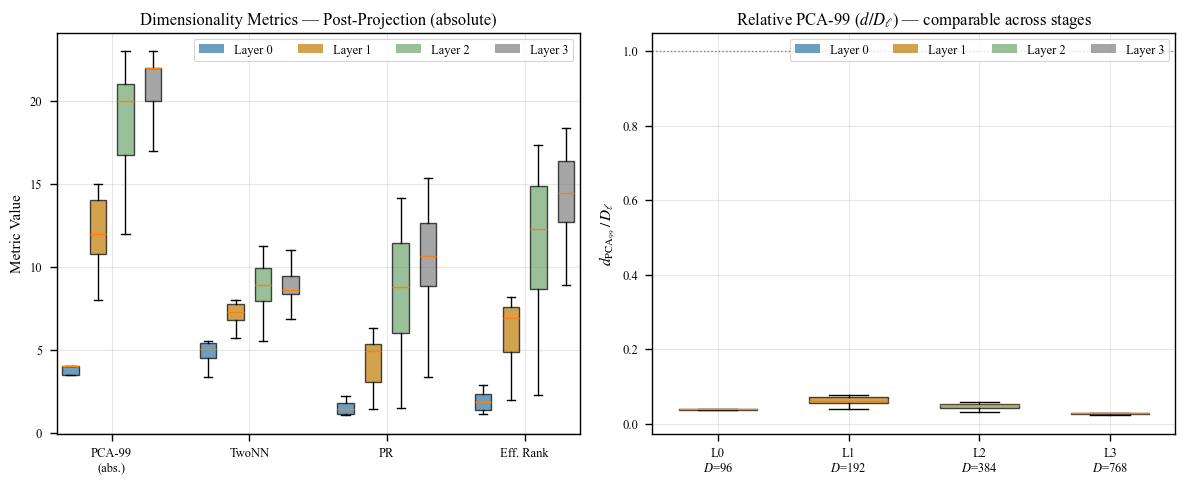

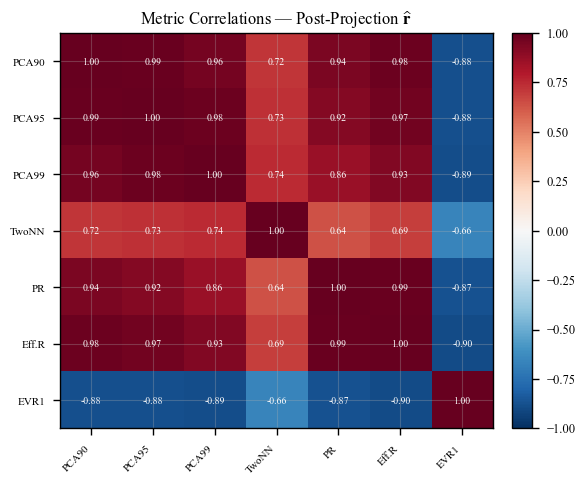

In [13]:
x_pos = np.arange(len(id_df))

# ── Panel A: PCA components (absolute) ───────────────────────────────────────
fig, ax = plt.subplots(figsize=(6, 4))
for layer in range(4):
    mask = id_df['layer'] == layer
    ax.scatter(x_pos[mask], id_df.loc[mask, 'pca_90'],
               c=layer_colors[layer], alpha=0.4, s=30, marker='o',
               label=f'L{layer} 90%')
    ax.scatter(x_pos[mask], id_df.loc[mask, 'pca_99'],
               c=layer_colors[layer], alpha=0.8, s=50, marker='s',
               label=f'L{layer} 99%')

# Annotate D_ell ceiling per stage
# cum = 0
# for layer_idx, depth in enumerate(HTSAT_DEPTHS):
#     n_heads_in_stage = depth * HTSAT_HEADS[layer_idx]
#     x_mid = cum + n_heads_in_stage / 2
#     ax.hlines(STAGE_DIMS[layer_idx], cum, cum + n_heads_in_stage,
#               colors=layer_colors[layer_idx], linestyles=':', linewidth=1.2,
#               alpha=0.5, label=f'$D_{layer_idx}$={STAGE_DIMS[layer_idx]}' if layer_idx == 0 else '')
#     ax.text(x_mid, STAGE_DIMS[layer_idx] + 3, f'$D_{layer_idx}$',
#             ha='center', fontsize=8, color=layer_colors[layer_idx], alpha=0.8)
#     cum += n_heads_in_stage
# 
ax.set_xlabel('Head Index (sequential)')
ax.set_ylabel('# Principal Components')
ax.set_title(r'Linear Dim.: PCA Components — Post-Projection $\widehat{\mathbf{r}}$')
ax.legend(ncol=4, loc='upper left', framealpha=0.9, fontsize=7)
ax.set_ylim(0, 30)
plt.tight_layout()
plt.savefig('postproj_panel_A_pca_components.png', dpi=300)
plt.show()

# ── Panel A2: PCA_99 normalised by D_ell (relative dimensionality) ────────────
# This is the cross-stage-comparable version: what fraction of the ambient
# space does each head effectively use?
fig, ax = plt.subplots(figsize=(6, 4))
for layer in range(4):
    mask    = id_df['layer'] == layer
    D_ell   = STAGE_DIMS[layer]
    rel_99  = id_df.loc[mask, 'pca_99'] / D_ell
    rel_90  = id_df.loc[mask, 'pca_90'] / D_ell
    ax.scatter(x_pos[mask], rel_90, c=layer_colors[layer], alpha=0.4, s=30,
               marker='o', label=f'L{layer} 90%')
    ax.scatter(x_pos[mask], rel_99, c=layer_colors[layer], alpha=0.8, s=50,
               marker='s', label=f'L{layer} 99%')

ax.axhline(1.0, color='gray', linestyle=':', linewidth=1)
ax.set_xlabel('Head Index (sequential)')
ax.set_ylabel(r'PCA components / $D_\ell$')
ax.set_title(r'Relative Dimensionality: $d_{\mathrm{PCA}} / D_\ell$ — Post-Projection')
ax.legend(ncol=4, loc='lower right', framealpha=0.9, fontsize=7)
ax.set_ylim(0, 0.1)
plt.tight_layout()
plt.savefig('postproj_panel_A2_pca_relative.png', dpi=300)
plt.show()

# ── Panel B: TwoNN ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6, 4))
for layer in range(4):
    mask = id_df['layer'] == layer
    ax.scatter(x_pos[mask], id_df.loc[mask, 'twonn'],
               c=layer_colors[layer], alpha=0.7, s=50, label=f'Layer {layer}')
ax.set_xlabel('Head Index')
ax.set_ylabel('TwoNN Dimension')
ax.set_title(r'Nonlinear ID: TwoNN — Post-Projection $\widehat{\mathbf{r}}$')
ax.set_ylim(bottom=0)
ax.legend(fontsize=8)
plt.tight_layout()
plt.savefig('postproj_panel_B_twonn.png', dpi=300)
plt.show()

# ── Panel C: MLE ──────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6, 4))
for layer in range(4):
    mask = id_df['layer'] == layer
    ax.scatter(x_pos[mask], id_df.loc[mask, 'mle'],
               c=layer_colors[layer], alpha=0.7, s=50, label=f'Layer {layer}')
ax.set_xlabel('Head Index')
ax.set_ylabel('MLE Dimension')
ax.set_title(r'Nonlinear ID: MLE — Post-Projection $\widehat{\mathbf{r}}$')
ax.set_ylim(bottom=0)
ax.legend(fontsize=8)
plt.tight_layout()
plt.savefig('postproj_panel_C_mle.png', dpi=300)
plt.show()

# ── Panel D: Participation Ratio ──────────────────────────────────────────────
legend_elements = [mpatches.Patch(facecolor=layer_colors[l], alpha=0.7, label=f'Layer {l}')
                   for l in range(4)]
fig, ax = plt.subplots(figsize=(6, 4))
for layer in range(4):
    mask = id_df['layer'] == layer
    ax.scatter(x_pos[mask], id_df.loc[mask, 'pr'],
               c=layer_colors[layer], alpha=0.7, s=50)
ax.set_xlabel('Head Index')
ax.set_ylabel('Participation Ratio')
ax.set_title(r'Effective Dim. (PR) — Post-Projection $\widehat{\mathbf{r}}$')
ax.legend(handles=legend_elements, fontsize=8)
plt.tight_layout()
plt.savefig('postproj_panel_D_participation_ratio.png', dpi=300)
plt.show()

# ── Panel E: Effective Rank ───────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6, 4))
for layer in range(4):
    mask = id_df['layer'] == layer
    ax.scatter(x_pos[mask], id_df.loc[mask, 'eff_rank'],
               c=layer_colors[layer], alpha=0.7, s=50)
ax.set_xlabel('Head Index')
ax.set_ylabel('Effective Rank')
ax.set_title(r'Effective Rank — Post-Projection $\widehat{\mathbf{r}}$')
ax.legend(handles=legend_elements, fontsize=8)
plt.tight_layout()
plt.savefig('postproj_panel_E_effective_rank.png', dpi=300)
plt.show()

# ── Panel F: PC1 Dominance ────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6, 4))
for layer in range(4):
    mask = id_df['layer'] == layer
    ax.scatter(x_pos[mask], id_df.loc[mask, 'evr_pc1'] * 100,
               c=layer_colors[layer], alpha=0.7, s=50)
threshold_line = ax.axhline(y=50, color=COLORS['accent'], linestyle='--',
                            alpha=0.5, label='50% threshold')
ax.legend(handles=legend_elements + [threshold_line], fontsize=8)
ax.set_xlabel('Head Index')
ax.set_ylabel('PC1 Variance Explained (%)')
ax.set_title(r'PC1 Dominance — Post-Projection $\widehat{\mathbf{r}}$')
plt.tight_layout()
plt.savefig('postproj_panel_F_pc1_dominance.png', dpi=300)
plt.show()

# ── Panel G: Boxplot comparison ───────────────────────────────────────────────
# Note: pca_99 distributions are NOT directly comparable across stages
# (different ceilings). We show both absolute and relative versions.
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax_idx, (metric, ylabel, title_suffix) in enumerate([
    ('pca_99', '# PCA components (absolute)',   'Absolute'),
]):
    ax = axes[ax_idx] if ax_idx < 2 else axes[0]
    metrics_to_plot = ['pca_99', 'twonn', 'pr', 'eff_rank']
    positions, colors_list, data_to_plot = [], [], []
    for i, m in enumerate(metrics_to_plot):
        for layer in range(4):
            layer_data = id_df[id_df['layer'] == layer][m].dropna()
            positions.append(i * 5 + layer)
            colors_list.append(layer_colors[layer])
            data_to_plot.append(layer_data)

    bp = axes[0].boxplot(data_to_plot, positions=positions, widths=0.6,
                         patch_artist=True, showfliers=False)
    for patch, color in zip(bp['boxes'], colors_list):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    axes[0].set_xticks([i * 5 + 1.5 for i in range(4)])
    axes[0].set_xticklabels(['PCA-99\n(abs.)', 'TwoNN', 'PR', 'Eff. Rank'])
    axes[0].set_ylabel('Metric Value')
    axes[0].set_title(r'Dimensionality Metrics — Post-Projection (absolute)')
    axes[0].legend(handles=legend_elements, loc='upper right', ncol=4)

# Right panel: relative pca_99 = pca_99 / D_ell
rel_data, rel_pos, rel_colors = [], [], []
for layer in range(4):
    D_ell = STAGE_DIMS[layer]
    vals  = id_df[id_df['layer'] == layer]['pca_99'].dropna() / D_ell
    rel_data.append(vals)
    rel_pos.append(layer)
    rel_colors.append(layer_colors[layer])

bp2 = axes[1].boxplot(rel_data, positions=rel_pos, widths=0.6,
                      patch_artist=True, showfliers=False)
for patch, color in zip(bp2['boxes'], rel_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1].set_xticks(range(4))
axes[1].set_xticklabels([f'L{l}\n$D$={STAGE_DIMS[l]}' for l in range(4)])
axes[1].set_ylabel(r'$d_{\mathrm{PCA}_{99}} \,/\, D_\ell$')
axes[1].set_title(r'Relative PCA-99 ($d / D_\ell$) — comparable across stages')
axes[1].axhline(1.0, color='gray', linestyle=':', linewidth=1)
axes[1].legend(handles=legend_elements, loc='upper right', ncol=4)

plt.tight_layout()
plt.savefig('postproj_panel_G_boxplot.png', dpi=300)
plt.show()

# ── Panel H: Correlation Heatmap ──────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6, 5))
corr_metrics  = ['pca_90', 'pca_95', 'pca_99', 'twonn', 'pr', 'eff_rank', 'evr_pc1']
corr_matrix   = id_df[corr_metrics].corr()
im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
labels = ['PCA90', 'PCA95', 'PCA99', 'TwoNN', 'PR', 'Eff.R', 'EVR1']
ax.set_xticks(range(len(corr_metrics)))
ax.set_yticks(range(len(corr_metrics)))
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(labels, fontsize=8)
ax.set_title(r'Metric Correlations — Post-Projection $\widehat{\mathbf{r}}$')
for i in range(len(corr_metrics)):
    for j in range(len(corr_metrics)):
        v = corr_matrix.iloc[i, j]
        ax.text(j, i, f'{v:.2f}', ha='center', va='center', fontsize=7,
                color='white' if abs(v) > 0.5 else 'black')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig('postproj_panel_H_corr_heatmap.png', dpi=300)
plt.show()

## Cell 5 — Spectral Fingerprinting

Scatter of $d_{\mathrm{PCA}_{99}}$ vs. spectral entropy. To make the
cross-stage picture interpretable we show both the raw plot and a version
where pca_99 is normalised by $D_\ell$.


SPECTRAL FINGERPRINTING
✓ Saved: postproj_spectral_fingerprinting.pdf/png


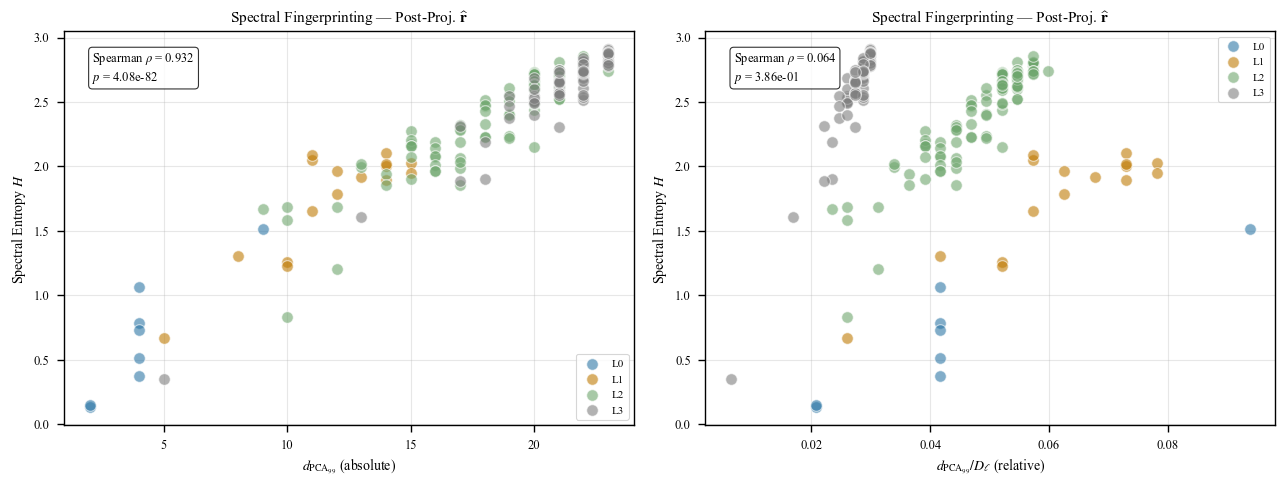

In [6]:
print("\n" + "=" * 80)
print("SPECTRAL FINGERPRINTING")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

for ax, x_col, xlabel in [
    (axes[0], 'pca_99',   r'$d_{\mathrm{PCA}_{99}}$ (absolute)'),
    (axes[1], 'pca_99_rel', r'$d_{\mathrm{PCA}_{99}} / D_\ell$ (relative)'),
]:
    if x_col == 'pca_99_rel':
        x_vals = id_df['pca_99'] / id_df['D_ell']
    else:
        x_vals = id_df['pca_99']

    for layer in range(4):
        mask = id_df['layer'] == layer
        ax.scatter(x_vals[mask], id_df.loc[mask, 'shannon_entropy'],
                   c=layer_colors[layer], label=f'L{layer}',
                   s=70, alpha=0.6, edgecolors='white', linewidth=0.8)

    rho, pval = spearmanr(x_vals.dropna(),
                          id_df.loc[x_vals.notna(), 'shannon_entropy'])
    ax.text(0.05, 0.95, f'Spearman $\\rho$ = {rho:.3f}\n$p$ = {pval:.2e}',
            transform=ax.transAxes, fontsize=9, va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(r'Spectral Entropy $H$', fontsize=10)
    ax.set_title(r'Spectral Fingerprinting — Post-Proj. $\widehat{\mathbf{r}}$',
                 fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('postproj_spectral_fingerprinting.pdf', dpi=300, bbox_inches='tight')
plt.savefig('postproj_spectral_fingerprinting.png', dpi=300, bbox_inches='tight')
print("✓ Saved: postproj_spectral_fingerprinting.pdf/png")
plt.show()

## Cell 6 — Head Similarity Matrix

Same cosine similarity on eigenvalue spectra as pre-projection.
Because spectra have different lengths ($D_\ell$ components), we truncate
all spectra to `min(D_ell)` = 96 before computing cosine similarity,
ensuring a fair within- and cross-stage comparison.


HEAD SIMILARITY MATRIX
   Spectrum length used: 96 (= min D_ell)
✓ Saved: postproj_head_similarity_matrix.pdf/png


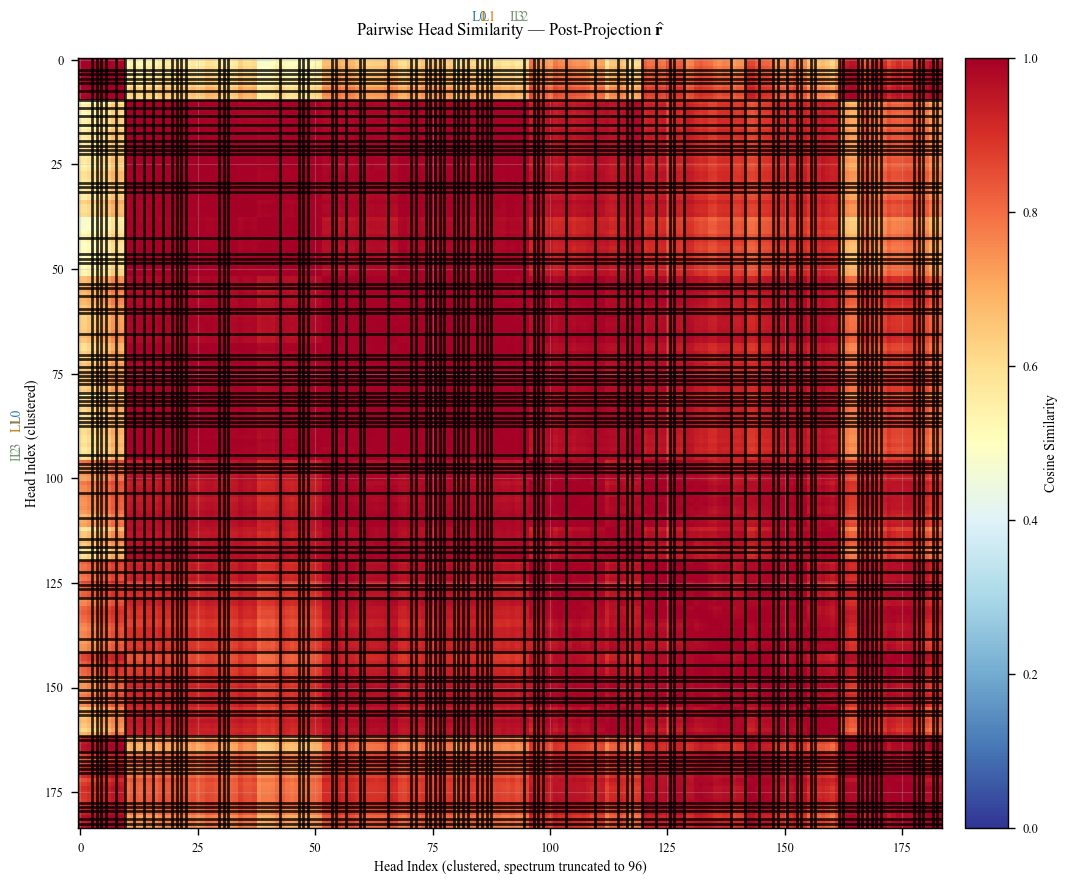


   Within-stage similarity : 0.943
   Cross-stage  similarity : 0.905
   Ratio                   : 1.04×


In [7]:
print("\n" + "=" * 80)
print("HEAD SIMILARITY MATRIX")
print("=" * 80)

SPECTRUM_LEN = min(STAGE_DIMS)   # 96: truncate to shortest stage

spectra = []
for head_id in sorted(postproj_head_outputs.keys()):
    row      = id_df[id_df['head_id'] == head_id].iloc[0]
    pca_obj  = row['pca_obj']
    ev       = pca_obj.explained_variance_
    # Truncate to SPECTRUM_LEN and L1-normalise
    spectrum = ev[:SPECTRUM_LEN]
    spectrum = spectrum / (spectrum.sum() + 1e-10)
    spectra.append(spectrum)

spectra = np.array(spectra)
print(f"   Spectrum length used: {SPECTRUM_LEN} (= min D_ell)")

similarity_matrix = cosine_similarity(spectra)
linkage_matrix    = linkage(pdist(spectra), method='ward')
dendro            = dendrogram(linkage_matrix, no_plot=True)
ordered_indices   = dendro['leaves']

similarity_ordered = similarity_matrix[ordered_indices, :][:, ordered_indices]
ordered_layers     = id_df.sort_values('head_id').iloc[ordered_indices]['layer'].values

fig = plt.figure(figsize=(12, 10))
gs  = GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)
ax  = fig.add_subplot(gs[0])

im = ax.imshow(similarity_ordered, cmap='RdYlBu_r', aspect='auto', vmin=0, vmax=1)

# Layer boundaries in the reordered matrix
current_layer = ordered_layers[0]
for i, layer in enumerate(ordered_layers):
    if layer != current_layer:
        ax.axhline(y=i - 0.5, color='black', linewidth=2, alpha=0.8)
        ax.axvline(x=i - 0.5, color='black', linewidth=2, alpha=0.8)
        current_layer = layer

# Layer labels
layer_positions = {}
for layer in range(4):
    idxs = np.where(ordered_layers == layer)[0]
    if len(idxs):
        layer_positions[layer] = (idxs[0], idxs[-1])
for layer, (start, end) in layer_positions.items():
    mid = (start + end) / 2
    ax.text(-12, mid, f'L{layer}', rotation=90, va='center', ha='right',
            fontsize=10, fontweight='bold', color=layer_colors[layer])
    ax.text(mid, -12, f'L{layer}', va='top', ha='center',
            fontsize=10, fontweight='bold', color=layer_colors[layer])

ax.set_xlabel(f'Head Index (clustered, spectrum truncated to {SPECTRUM_LEN})', fontsize=10)
ax.set_ylabel('Head Index (clustered)', fontsize=10)
ax.set_title(r'Pairwise Head Similarity — Post-Projection $\widehat{\mathbf{r}}$',
             fontsize=12, fontweight='bold', pad=16)

cax  = fig.add_subplot(gs[1])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Cosine Similarity', fontsize=10)

plt.savefig('postproj_head_similarity_matrix.pdf', dpi=300, bbox_inches='tight')
plt.savefig('postproj_head_similarity_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Saved: postproj_head_similarity_matrix.pdf/png")
plt.show()

# ── Similarity statistics ─────────────────────────────────────────────────────
head_index = list(sorted(postproj_head_outputs.keys()))
layers_arr = np.array([int(hid.split('_')[0][1]) for hid in head_index])

within_sims, cross_sims = [], []
for l1 in range(4):
    idx1 = np.where(layers_arr == l1)[0]
    if len(idx1) > 1:
        sub = similarity_matrix[np.ix_(idx1, idx1)]
        within_sims.extend(sub[np.triu_indices_from(sub, k=1)])
    for l2 in range(l1 + 1, 4):
        idx2 = np.where(layers_arr == l2)[0]
        cross_sims.extend(similarity_matrix[np.ix_(idx1, idx2)].flatten())

print(f"\n   Within-stage similarity : {np.mean(within_sims):.3f}")
print(f"   Cross-stage  similarity : {np.mean(cross_sims):.3f}")
print(f"   Ratio                   : {np.mean(within_sims)/np.mean(cross_sims):.2f}×")

## Cell 7 — Class-Conditional Activation Heatmap + Fisher Score

Mirrors the pre-projection class-conditional analysis.
Block representations are now the **mean over heads** of
$\widehat{\mathbf{r}}_{\ell,b,h}$ (all in $\mathbb{R}^{D_\ell}$),
so each block has a different feature dimension.
The Fisher score is computed per block in its native space; the
z-scoring of the activation heatmap is done per block (column-wise)
so the visualisation is stage-agnostic.


CLASS-CONDITIONAL ANALYSIS + FISHER SCORE
   Block  0 (L0, D=96): shape (2000, 96)
   Block  1 (L0, D=96): shape (2000, 96)
   Block  2 (L1, D=192): shape (2000, 192)
   Block  3 (L1, D=192): shape (2000, 192)
   Block  4 (L2, D=384): shape (2000, 384)
   Block  5 (L2, D=384): shape (2000, 384)
   Block  6 (L2, D=384): shape (2000, 384)
   Block  7 (L2, D=384): shape (2000, 384)
   Block  8 (L2, D=384): shape (2000, 384)
   Block  9 (L2, D=384): shape (2000, 384)
   Block 10 (L3, D=768): shape (2000, 768)
   Block 11 (L3, D=768): shape (2000, 768)
   Block  0 (L0): F = 1.1565
   Block  1 (L0): F = 1.1154
   Block  2 (L1): F = 1.0016
   Block  3 (L1): F = 0.8452
   Block  4 (L2): F = 0.9413
   Block  5 (L2): F = 0.9080
   Block  6 (L2): F = 0.6345
   Block  7 (L2): F = 0.5335
   Block  8 (L2): F = 0.6632
   Block  9 (L2): F = 0.7031
   Block 10 (L3): F = 1.1703
   Block 11 (L3): F = 1.5242
✓ Saved: postproj_class_activation_heatmap.pdf/png


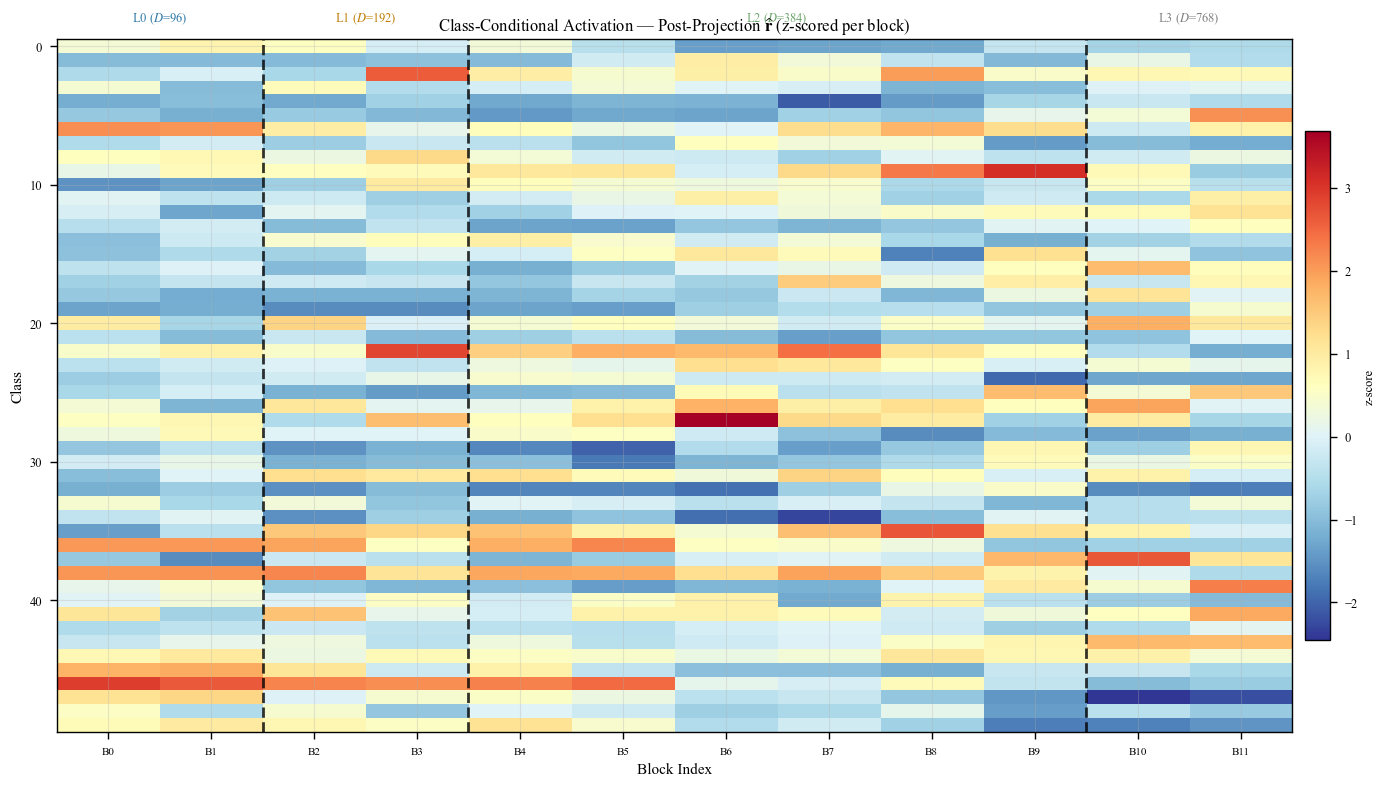

✓ Saved: postproj_fisher_discriminability.pdf/png


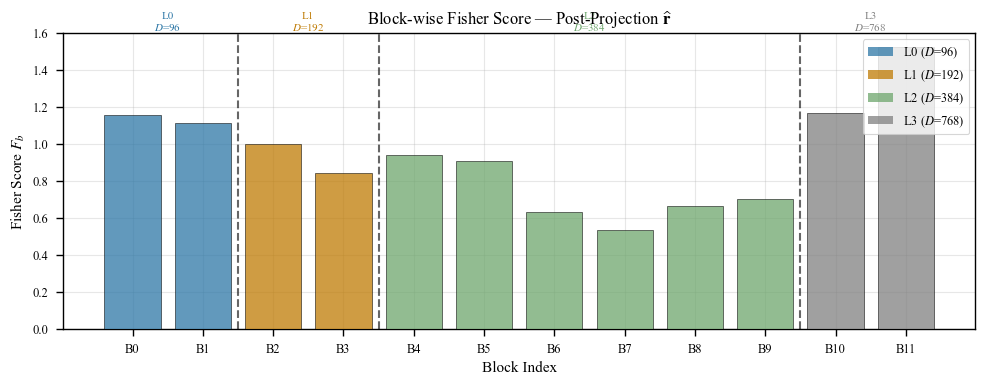


✅ All post-projection plots generated.
   Files saved:
   - htsat_block_metrics_postproj.png
   - postproj_panel_A_pca_components.png
   - postproj_panel_A2_pca_relative.png
   - postproj_panel_B_twonn.png
   - postproj_panel_C_mle.png
   - postproj_panel_D_participation_ratio.png
   - postproj_panel_E_effective_rank.png
   - postproj_panel_F_pc1_dominance.png
   - postproj_panel_G_boxplot.png
   - postproj_panel_H_corr_heatmap.png
   - postproj_spectral_fingerprinting.pdf/png
   - postproj_head_similarity_matrix.pdf/png
   - postproj_class_activation_heatmap.pdf/png
   - postproj_fisher_discriminability.pdf/png


In [8]:
print("\n" + "=" * 80)
print("CLASS-CONDITIONAL ANALYSIS + FISHER SCORE")
print("=" * 80)

# Build block representations: mean of Ĥ heads within each block
block_to_heads = defaultdict(list)
block_layer_map = []
global_block = 0
for layer_idx, depth in enumerate(HTSAT_DEPTHS):
    for block_idx in range(depth):
        for h in range(HTSAT_HEADS[layer_idx]):
            block_to_heads[global_block].append(f"L{layer_idx}_B{block_idx}_H{h}")
        block_layer_map.append(layer_idx)
        global_block += 1

block_representations = {}
for b in range(n_blocks):
    stacked = np.stack(
        [postproj_head_outputs[hid].numpy() for hid in block_to_heads[b]], axis=0
    )
    block_representations[b] = stacked.mean(axis=0)  # (N_samples, D_ell)
    print(f"   Block {b:2d} (L{block_layer_map[b]}, D={STAGE_DIMS[block_layer_map[b]]}): "
          f"shape {block_representations[b].shape}")

# Fisher score per block
def fisher_score(X, y):
    classes   = np.unique(y)
    mu_global = X.mean(axis=0)
    S_B = np.zeros(X.shape[1])
    S_W = np.zeros(X.shape[1])
    for c in classes:
        X_c  = X[y == c]
        mu_c = X_c.mean(axis=0)
        S_B += len(X_c) * (mu_c - mu_global) ** 2
        S_W += ((X_c - mu_c) ** 2).sum(axis=0)
    return float((S_B / (S_W + 1e-8)).mean())

fisher_scores = {}
for b in range(n_blocks):
    fisher_scores[b] = fisher_score(block_representations[b], sample_labels)
    print(f"   Block {b:2d} (L{block_layer_map[b]}): F = {fisher_scores[b]:.4f}")

# ── Activation heatmap ────────────────────────────────────────────────────────
heatmap = np.zeros((n_classes, n_blocks))
for b in range(n_blocks):
    X = block_representations[b]
    for c in range(n_classes):
        X_c = X[sample_labels == c]
        heatmap[c, b] = np.linalg.norm(X_c.mean(axis=0))

heatmap_norm = (heatmap - heatmap.mean(axis=0, keepdims=True)) / \
               (heatmap.std(axis=0, keepdims=True) + 1e-8)

layer_boundaries_plot = []
cum = 0
for depth in HTSAT_DEPTHS[:-1]:
    cum += depth
    layer_boundaries_plot.append(cum - 0.5)

fig, ax = plt.subplots(figsize=(14, 8))
im = ax.imshow(heatmap_norm, aspect='auto', cmap='RdYlBu_r', interpolation='nearest')

for boundary in layer_boundaries_plot:
    ax.axvline(x=boundary, color='black', linewidth=2, linestyle='--', alpha=0.8)

cum = 0
for layer_idx, depth in enumerate(HTSAT_DEPTHS):
    mid = cum + depth / 2 - 0.5
    ax.text(mid, -1.5, f'L{layer_idx} ($D$={STAGE_DIMS[layer_idx]})',
            ha='center', va='bottom', fontsize=9,
            fontweight='bold', color=layer_colors[layer_idx])
    cum += depth

ax.set_xticks(range(n_blocks))
ax.set_xticklabels([f'B{b}' for b in range(n_blocks)], fontsize=8)
ax.set_xlabel('Block Index', fontsize=11)
ax.set_ylabel('Class', fontsize=11)
ax.set_title(r'Class-Conditional Activation — Post-Projection $\widehat{\mathbf{r}}$ (z-scored per block)',
             fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax, fraction=0.02, pad=0.01).set_label('z-score', fontsize=9)
plt.tight_layout()
plt.savefig('postproj_class_activation_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.savefig('postproj_class_activation_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Saved: postproj_class_activation_heatmap.pdf/png")
plt.show()

# ── Fisher score bar chart ────────────────────────────────────────────────────
f_vals = [fisher_scores[b] for b in range(n_blocks)]

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(range(n_blocks), f_vals,
       color=[layer_colors[block_layer_map[b]] for b in range(n_blocks)],
       alpha=0.75, edgecolor='black', linewidth=0.5, zorder=3)
for boundary in layer_boundaries_plot:
    ax.axvline(x=boundary, color='black', linestyle='--', linewidth=1.5, alpha=0.6)
cum = 0
for layer_idx, depth in enumerate(HTSAT_DEPTHS):
    mid = cum + depth / 2 - 0.5
    ax.text(mid, max(f_vals) * 1.05,
            f'L{layer_idx}\n$D$={STAGE_DIMS[layer_idx]}',
            ha='center', va='bottom', fontsize=8,
            fontweight='bold', color=layer_colors[layer_idx])
    cum += depth
ax.set_xticks(range(n_blocks))
ax.set_xticklabels([f'B{b}' for b in range(n_blocks)])
ax.set_xlabel('Block Index', fontsize=11)
ax.set_ylabel(r'Fisher Score $F_b$', fontsize=11)
ax.set_title(r'Block-wise Fisher Score — Post-Projection $\widehat{\mathbf{r}}$',
             fontsize=12, fontweight='bold')
ax.legend(handles=[Patch(facecolor=layer_colors[i], alpha=0.75,
                         label=f'L{i} ($D$={STAGE_DIMS[i]})') for i in range(4)],
          loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('postproj_fisher_discriminability.pdf', dpi=300, bbox_inches='tight')
plt.savefig('postproj_fisher_discriminability.png', dpi=300, bbox_inches='tight')
print("✓ Saved: postproj_fisher_discriminability.pdf/png")
plt.show()

print("\n✅ All post-projection plots generated.")
print("   Files saved:")
for fname in [
    'htsat_block_metrics_postproj.png',
    'postproj_panel_A_pca_components.png',
    'postproj_panel_A2_pca_relative.png',
    'postproj_panel_B_twonn.png',
    'postproj_panel_C_mle.png',
    'postproj_panel_D_participation_ratio.png',
    'postproj_panel_E_effective_rank.png',
    'postproj_panel_F_pc1_dominance.png',
    'postproj_panel_G_boxplot.png',
    'postproj_panel_H_corr_heatmap.png',
    'postproj_spectral_fingerprinting.pdf/png',
    'postproj_head_similarity_matrix.pdf/png',
    'postproj_class_activation_heatmap.pdf/png',
    'postproj_fisher_discriminability.pdf/png',
]:
    print(f"   - {fname}")
